In [10]:
import csv
import sys
import random
import os
import math
import numpy as np
import numpy.linalg as npla
import scipy
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
%matplotlib tk

In [11]:
import sys
sys.path.append("../Python_code") # go to parent dir
from reddit import *
from canvas_vis import *
from project_data_analysis import *

In [3]:
projects_to_remove = {'777', '1921', '1169', '42', '1066', '1757', '1824', '320', '998', '1870', '1811',\
                     '1925', '1927', '704', '1085', '1308', '1378', '1412', '1418', '1428', '1455', '1482',\
                      '1512', '1548', '1589', '1614', '1790', '1319', '939', '1263', '1383', '1155', '1761', 
                     '1524', '351', '129', '1046', '1073', '1595', '1254', '1528', '1529', '1578', '1616',\
                     '1721'}

In [4]:
project_dict = dict()
with open('../data/atlas_filtered.json') as f:
    data = json.load(f)
projects_count = 0
for element in data['atlas']:
    pic_id = int(element["id"])
    if pic_id not in projects_to_remove:
        project_dict[pic_id] = projects_count
        projects_count += 1

In [5]:
users_dict = dict()
users_count = 0
with open("../data/tile_placements.csv",'r') as file:
    # Skip first line (header row)
    next(file, None)

    reader = csv.reader(file)
    
    for r in reader:
        user = r[1]
        if user not in users_dict:
            users_dict[user] = users_count
            users_count += 1

In [6]:
users_count

1166924

In [7]:
%%time 
#1 - Position (i,j) is the number of pixels by user i in project j (final)
type1 = np.zeros((users_count, projects_count))
#2 - Position (i,j) is the number of updates by user i that agree with pixels in project j.
type2 = np.zeros((users_count, projects_count))
#3 - Position (i,j) is the number of updates by user i that in the bounding area of project j and disagree with that pixel in j. These are updates likely against the project.
type3 = np.zeros((users_count, projects_count))
    

users_per_project = dict()
with open("../data/tile_placements_proj.csv", "r") as file:
    reader = csv.reader(file, delimiter = ",")
     # Skip first line (header row)
    next(file, None)
    # user:1, pic_id: 5, pixel: 6, pixel_color: 7
    for r in reader:
        user = r[1]
        pic_id = int(r[5])
        pixel = int(r[6])
        pixel_color = int(r[7])

        try:
            if pic_id not in projects_to_remove:

                if pic_id not in users_per_project:
                    users_per_project[pic_id] = set()

                users_per_project[pic_id].add(user)

                if pixel == 1:
                    type1[users_dict[user],project_dict[pic_id]] += 1

                if pixel_color == 1:
                    type2[users_dict[user],project_dict[pic_id]] += 1

                elif pixel_color == 0:
                    type3[users_dict[user],project_dict[pic_id]] += 1
        except Exception as e:
            print(e)
            print(pic_id)
            print(user)
            break
 
    type1 = sparse.csr_matrix(type1)
    type2 = sparse.csr_matrix(type2)
    type3 = sparse.csr_matrix(type3)


CPU times: user 4min 4s, sys: 1min 53s, total: 5min 58s
Wall time: 6min 36s


In [8]:
# Calculate average users per project
average_num_users = int(users_count / len(users_per_project))
print(average_num_users)

615


In [9]:
%%time
"""
    Type1 matrix: position (i,j) is the number of pixels by user i in project j 
"""

# Syntax:
# euc_dist = distance.euclidean(a,b)
# cos_dist = distance.cosine(a,b)

"""
    user_euc_dist and user_cos_dist is a dictionary of the following format:
        pic_id: user_distance list
    Create a new list for every project where every element is the euclidean distance or
    cosine distance between two users in a project.
    
    user_distances is a dictionary that stores the distance between two user vectors so we do not have to recompute it.
"""

users_euc_dist = dict()  # Position (i,j) is the euclidean distance between user vectors i and j
users_cos_dist = dict()  # Position (i,j) is the cosine distance between user vectors i and j
user_distances = dict()

# Calculating distance between every pair of users takes too long. (Several years)
# Sample at most 100 users for each project
sample_size = 100

for pic_id in users_per_project:
    all_users = list(users_per_project.get(pic_id))
#     print(len(all_users))
    
    
    if len(all_users) > sample_size:
        all_users = random.sample(all_users, sample_size)

    users_euc_dist[pic_id] = []
    users_cos_dist[pic_id] = []
#     print(user_matrix[pic_id].shape())
    
    for i in range(len(all_users)):
        user1 = all_users[i]
        
        # If the user has no contributions that made it to the final canvas, then skip him
        if np.sum(type1[users_dict[user1], : ]) == 0:
            continue
        
        for j in range(i + 1, len(all_users)):
            
            # If the user has no contributions that made it to the final canvas, then skip him
            user2 = all_users[j]
            if np.sum(type1[users_dict[user2], : ]) == 0:
                continue
            
            
            # Make sure user1 is the smaller value
            if user2 < user1:
                temp = user2
                user2 = user1
                user1 = temp
                
            if (user1, user2) not in user_distances:
                
                vec1 = type1[users_dict[user1], : ].toarray()
                vec2 = type1[users_dict[user2], :].toarray()
                euc_dist = distance.euclidean( vec1 , vec2 )
                cos_dist = distance.cosine( vec1 , vec2 )

                user_distances[(user1, user2)] = (euc_dist, cos_dist)

            users_euc_dist[pic_id].append(user_distances[(user1, user2)][0])
            users_cos_dist[pic_id].append(user_distances[(user1, user2)][1])
    
    

CPU times: user 11min 45s, sys: 5.25 s, total: 11min 50s
Wall time: 11min 49s


ValueError: num must be 1 <= num <= 1, not 2

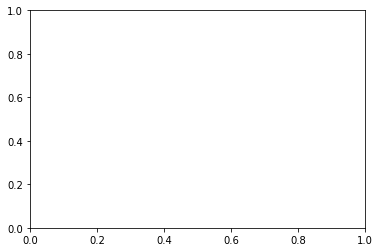

In [20]:
%matplotlib inline
# plot the user distances of a single project given the pic_id
# Testing on some pic_ids
def plot_distances_icdf(count, pic_id):
    euc_dict = dict()
    cos_dict = dict()
    for i in range(len(users_euc_dist[pic_id])):
        euc_dict[i] = int(users_euc_dist[pic_id][i]*1000)
        cos_dict[i] = int(users_cos_dist[pic_id][i]*1000)
        
    plt.clf()

    #Computing ICDF
    count_euc = icdf(euc_dict)
    count_cos = icdf(cos_dict)
    ax = plt.subplot(111)
    ax2 = plt.subplot(112)
    ax.plot(np.arange(count_euc.shape[0])/1000, count_euc, color="red", linewidth=4, label="euclidean distance")
    ax2.plot(np.arange(count_cos.shape[0])/1000, count_cos, color="blue", linewidth=4, label="cosine distance")
    ax.set_ylabel('ICDF', fontsize=30)
    ax.set_xlabel('distance between users', fontsize=30)
    ax.tick_params(labelsize=23)
    #ax.set_xlim(1, 1000000)
    ax.legend()
    ax.set_title('user distances plot for pic_id: '+str(pic_id))
    #plt.savefig(output_file_name, dpi=300, bbox_inches='tight')

plot_distances_icdf(count, 23)
